In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
import catboost as cb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
from sklearn.ensemble import RandomForestRegressor


In [7]:
# Load data
data = pd.read_parquet("Data/DSB_BDK_trainingset.parquet")

In [8]:
combinations = data[['visualiseringskode', 'station']].drop_duplicates().values
for strækning, station in combinations:
    print(data[(data['visualiseringskode'] == strækning) & (data['station'] == station)].shape)

(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)


In [9]:
import ast
best_model_parameters = {}
model_params_sarima = pd.read_csv('Data/Best_model_parameters_SARIMA_strækning_station.csv')
list(model_params_sarima.items())
for i in range(model_params_sarima.shape[0]):
    tuple_result = ast.literal_eval(model_params_sarima['Key'][i])
    list_result = ast.literal_eval(model_params_sarima['Values'][i])
    best_model_parameters[tuple_result] = list_result

In [10]:
best_model_parameters

{(1, 0): [(1, 1, 1), (0, 0, 0, 0)],
 (2, 0): [(3, 1, 5), (0, 0, 0, 0)],
 (1, 1): [(0, 1, 2), (0, 0, 0, 0)],
 (2, 2): [(1, 1, 1), (0, 0, 0, 0)],
 (9, 2): [(1, 1, 3), (0, 0, 0, 0)],
 (10, 3): [(1, 1, 3), (0, 0, 0, 0)],
 (24, 3): [(2, 1, 1), (0, 0, 0, 0)],
 (21, 4): [(1, 1, 1), (0, 0, 0, 0)],
 (10, 5): [(5, 1, 2), (0, 0, 0, 0)],
 (8, 5): [(0, 1, 2), (0, 0, 0, 0)],
 (11, 6): [(1, 1, 3), (0, 0, 0, 0)],
 (13, 6): [(1, 1, 3), (0, 0, 0, 0)],
 (9, 6): [(1, 1, 1), (0, 0, 0, 0)],
 (1, 7): [(1, 1, 1), (0, 0, 0, 0)],
 (2, 8): [(1, 1, 1), (0, 0, 0, 0)],
 (20, 9): [(0, 1, 2), (0, 0, 0, 0)],
 (1, 10): [(1, 1, 1), (0, 0, 0, 0)],
 (17, 11): [(2, 1, 3), (0, 0, 0, 0)],
 (28, 12): [(1, 1, 3), (0, 0, 0, 0)],
 (5, 12): [(0, 1, 2), (0, 0, 0, 0)],
 (5, 13): [(1, 1, 1), (0, 0, 0, 0)],
 (6, 13): [(1, 1, 1), (0, 0, 0, 0)],
 (7, 13): [(0, 1, 2), (0, 0, 0, 0)],
 (19, 14): [(1, 1, 1), (0, 0, 0, 0)],
 (17, 15): [(0, 1, 2), (0, 0, 0, 0)],
 (11, 16): [(1, 1, 3), (0, 0, 0, 0)],
 (19, 17): [(0, 1, 2), (0, 0, 0, 0)],
 (20

In [46]:
def custom_cross_val_predict(estimator, y, X=None, cv=None, verbose=0, averaging="mean", return_raw_predictions=False, initial=2555):
    """Generate cross-validated estimates for each input data point
    
    Parameters
    ----------
    estimator : tuple
        A tuple containing two estimators. The first estimator should be the ARIMA model
        and the second one should be the Random Forest model.

    y : array-like or iterable, shape=(n_samples,)
        The time-series array.

    X : array-like, shape=[n_obs, n_vars], optional (default=None)
        An optional 2-d array of exogenous variables.

    cv : BaseTSCrossValidator or None, optional (default=None)
        An instance of cross-validation. If None, will use a RollingForecastCV.
        Note that for cross-validation predictions, the CV step cannot exceed
        the CV horizon, or there will be a gap between fold predictions.

    verbose : integer, optional
        The verbosity level.

    averaging : str or callable, one of ["median", "mean"] (default="mean")
        Unlike normal CV, time series CV might have different folds (windows)
        forecasting the same time step. After all forecast windows are made,
        we build a matrix of y x n_folds, populating each fold's forecasts like
        so::

            nan nan nan  # training samples
            nan nan nan
            nan nan nan
            nan nan nan
              1 nan nan  # test samples
              4   3 nan
              3 2.5 3.5
            nan   6   5
            nan nan   4

        We then average each time step's forecasts to end up with our final
        prediction results.

    return_raw_predictions : bool (default=False)
        If True, raw predictions are returned instead of averaged ones.
        This results in a y x h matrix. For example, if h=3, and step=1 then:

            nan nan nan # training samples
            nan nan nan
            nan nan nan
            nan nan nan
            1   4   2   # test samples
            2   5   7
            8   9   1
            nan nan nan
            nan nan nan

        First column contains all one-step-ahead-predictions, second column all
        two-step-ahead-predictions etc. Further metrics can then be calculated
        as desired.

    Returns
    -------
    predictions : array-like, shape=(n_samples,)
        The predicted values.

    """

    def indexable(*iterables):
        """Internal utility to handle input types"""
        results = []
        for iterable in iterables:
            if not hasattr(iterable, "__iter__"):
                raise ValueError("Input {!r} is not indexable".format(iterable))
            results.append(iterable)
        return results

    def check_cv(cv, initial = 2555):
        """Internal utility to check cv"""
        if cv is None:
            from pmdarima.model_selection import RollingForecastCV
            cv = RollingForecastCV(initial=initial, step=1, h=1)
        return cv

    def check_endog(y, copy=True, preserve_series=False):
        """Internal utility to check endogenous variable"""
        from pmdarima.utils import check_endog
        return check_endog(y, copy=copy, preserve_series=preserve_series)

    def _check_averaging(averaging):
        """Internal utility to check averaging"""
        if averaging == "mean":
            return np.nanmean
        elif averaging == "median":
            return np.nanmedian
        elif callable(averaging):
            return averaging
        else:
            raise ValueError("Unknown averaging method: {}".format(averaging))

    def _fit_and_predict(fold, estimator_tuple, y, X, train, test, verbose=0):
        """Internal utility to fit and predict"""
        arima_model = estimator_tuple
        # Fit ARIMA model
        arima_model.fit(y[train]) # X=X.iloc[train, :]
        # Predict with ARIMA model
        train_predictions = arima_model.predict_in_sample()
        arima_pred = arima_model.predict(n_periods=len(test))

        # Calculate residuals for RF input
        arima_residuals_train = train_predictions - y[train]
        
        # Model
        model = cb.CatBoostRegressor(objective = 'RMSE', iterations=20, learning_rate=0.1, max_depth=5) 
        # Define the parameters for the CatBoost classifier
        #param = {'objective':'reg:squarederror', 'booster':'gbtree', 'max_depth': 5}
 

        #steps = 20  # The number of training iterations

        # Train the model
        model.fit(X.iloc[train, :], arima_residuals_train)

        # Predict the labels of the test set
        preds = model.predict(X.iloc[test, :])
        # Overall prediction residuals = pred - true <=> true = pred - residuals
        overall_pred = np.array(max(min(1, arima_pred[0] - preds), 0)) # make sure it is in [0;1]

        return overall_pred, test, np.array(arima_pred) #arima_residuals_test

    y, X = indexable(y, X)
    y = check_endog(y, copy=False, preserve_series=True)
    cv = check_cv(cv, initial)
    avgfunc = _check_averaging(averaging)

    if cv.step > cv.horizon:
        raise ValueError("CV step cannot be > CV horizon, or there will be a gap in predictions between folds")

    prediction_blocks = [
        _fit_and_predict(fold,
                         estimator,
                         y,
                         X,
                         train=train,
                         test=test,
                         verbose=verbose,)  # TODO: fit params?
        for fold, (train, test) in enumerate(cv.split(y, X))]

    pred_matrix = np.ones((y.shape[0], len(prediction_blocks))) * np.nan
    arima_pred = []
    for i, (pred_block, test_indices, arima_block) in enumerate(prediction_blocks):
        pred_matrix[test_indices, i] = pred_block
        arima_pred.append(arima_block)

    if return_raw_predictions:
        predictions = np.ones((y.shape[0], cv.horizon)) * np.nan
        for pred_block, test_indices in prediction_blocks:
            predictions[test_indices[0]] = pred_block
        return predictions

    test_mask = ~(np.isnan(pred_matrix).all(axis=1))
    predictions = pred_matrix[test_mask]



    # Calculate CV score
    cv_scores = []
    cv_scores_arima = []
    for fold, (train, test) in enumerate(cv.split(y, X)):
        fold_predictions = pred_matrix[test, fold]
        fold_score = mean_squared_error(y[test], fold_predictions)
        fold_arima_score = mean_squared_error(y[test], arima_pred[fold])
        cv_scores.append(fold_score)
        cv_scores_arima.append(fold_arima_score)

    # Compute overall CV score
    score = np.mean(cv_scores)
    arima_score = np.mean(cv_scores_arima)

    return avgfunc(predictions, axis=1), score,  arima_score


In [63]:
import warnings
warnings.filterwarnings('ignore')

results_strækning_station = {}
combinations = data[['visualiseringskode', 'station']].drop_duplicates().values
MSEs = []
MSEs_arima = []
random_state = 42
initial_start = 2500
preds = {}

for strækning, station in combinations[:10]:
    y = data[(data['visualiseringskode'] == strækning) & (data['station'] == station)]['togpunktlighed']
    X = data[(data['visualiseringskode'] == strækning) & (data['station'] == station)].iloc[:,1:]
    arima_model = pm.arima.ARIMA(order = best_model_parameters[strækning, station][0], seasonal_order=best_model_parameters[strækning, station][1])

    pred, mse, mse_arima = custom_cross_val_predict((arima_model), y, X, cv=None, verbose=1, averaging="mean", return_raw_predictions=False, initial=initial_start)
    # output = prediction per fold. 
    MSEs.append(mse)
    MSEs_arima.append(mse_arima)
    preds[(strækning, station)] = pred
    # initial = 2457 - 100 fold, 10 combinations, n_estimators=100 -> 61 min

0:	learn: 0.1268810	total: 2.9ms	remaining: 55.1ms
1:	learn: 0.1250968	total: 4.54ms	remaining: 40.9ms
2:	learn: 0.1236557	total: 6.56ms	remaining: 37.2ms
3:	learn: 0.1214342	total: 8.09ms	remaining: 32.4ms
4:	learn: 0.1195992	total: 10.3ms	remaining: 30.8ms
5:	learn: 0.1185350	total: 11.9ms	remaining: 27.7ms
6:	learn: 0.1173902	total: 13.4ms	remaining: 24.9ms
7:	learn: 0.1165730	total: 15.1ms	remaining: 22.6ms
8:	learn: 0.1155555	total: 16.7ms	remaining: 20.5ms
9:	learn: 0.1144190	total: 18.4ms	remaining: 18.4ms
10:	learn: 0.1137798	total: 20.1ms	remaining: 16.5ms
11:	learn: 0.1127607	total: 21.6ms	remaining: 14.4ms
12:	learn: 0.1120048	total: 23.2ms	remaining: 12.5ms
13:	learn: 0.1112818	total: 24.7ms	remaining: 10.6ms
14:	learn: 0.1106655	total: 26.4ms	remaining: 8.79ms
15:	learn: 0.1102130	total: 28.1ms	remaining: 7.02ms
16:	learn: 0.1099868	total: 29.7ms	remaining: 5.24ms
17:	learn: 0.1097802	total: 31.3ms	remaining: 3.48ms
18:	learn: 0.1096947	total: 32.8ms	remaining: 1.73ms
19:	

In [68]:
len(pred)

57

In [69]:
MSEs

[0.0027901178015504063,
 0.007748203445435707,
 0.016327828018941417,
 0.0034873183823911453,
 0.010936553378969002,
 0.008354254713591476,
 0.0027199549789176892,
 0.00813482030003643,
 0.008716459084042654,
 0.006715877662811192]

In [70]:
MSEs_arima

[0.0031755999502939562,
 0.00850308499711265,
 0.017468226112063646,
 0.004007216020071928,
 0.014576125932030837,
 0.010183166919004288,
 0.003205403006313849,
 0.0139059697966677,
 0.010453655320574852,
 0.007425634066129838]

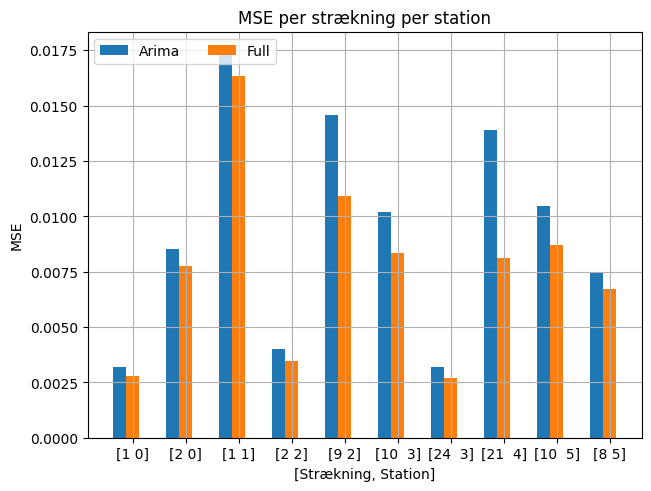

In [71]:
x = np.arange(len(MSEs))

width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in [['Arima', MSEs_arima], ['Full', MSEs]]:
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1
ax.legend(loc='upper left', ncols=2)
ax.set_xticks(x + width, combinations[:10])
ax.set_xlabel('[Strækning, Station]')
ax.set_ylabel('MSE')
ax.set_title('MSE per strækning per station')
ax.grid()

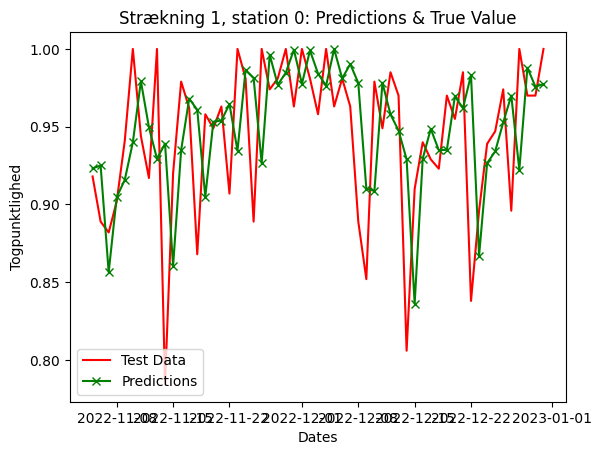

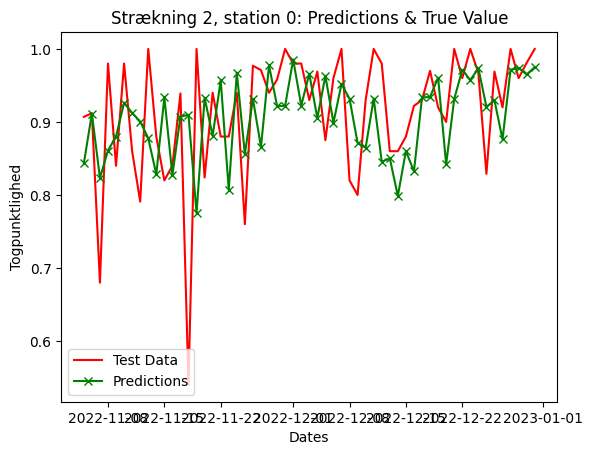

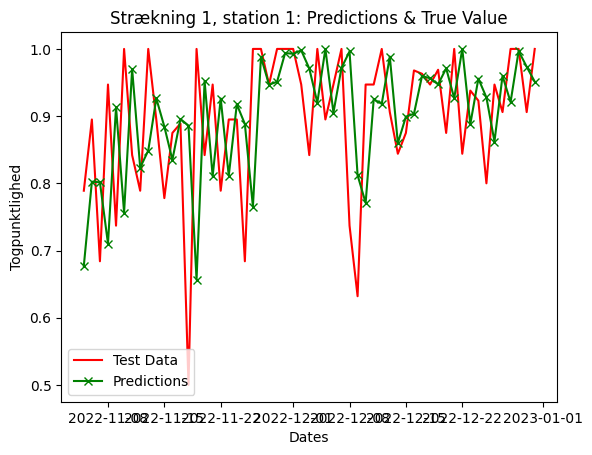

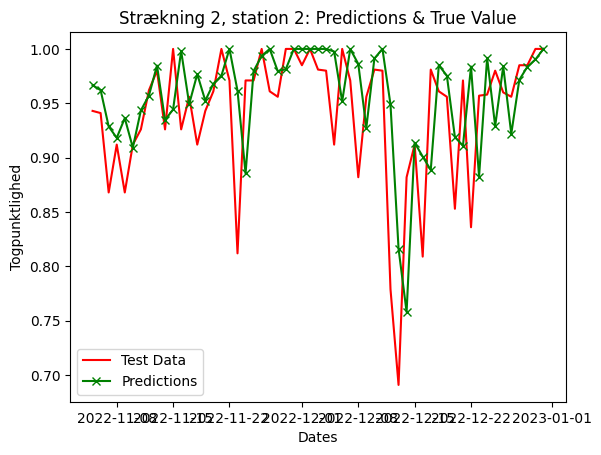

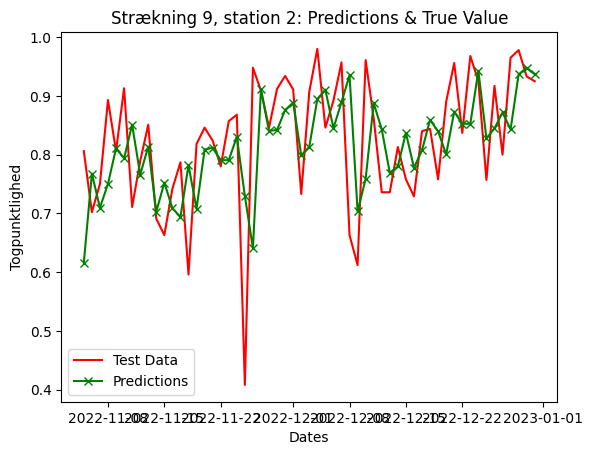

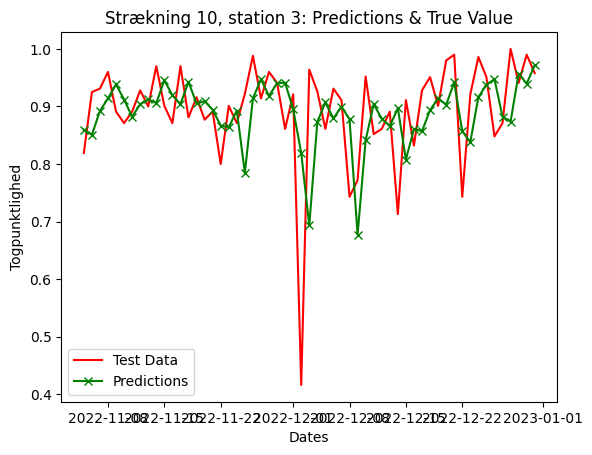

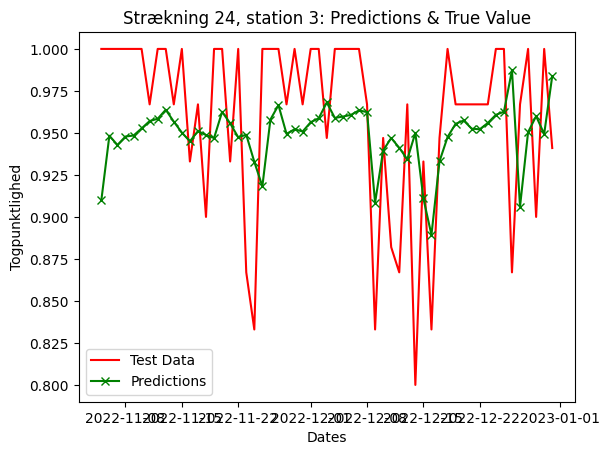

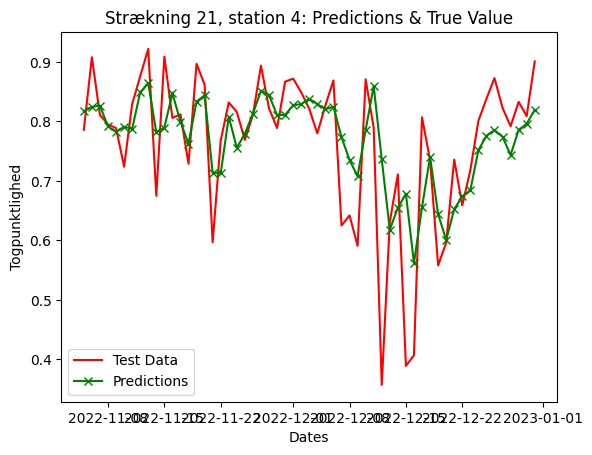

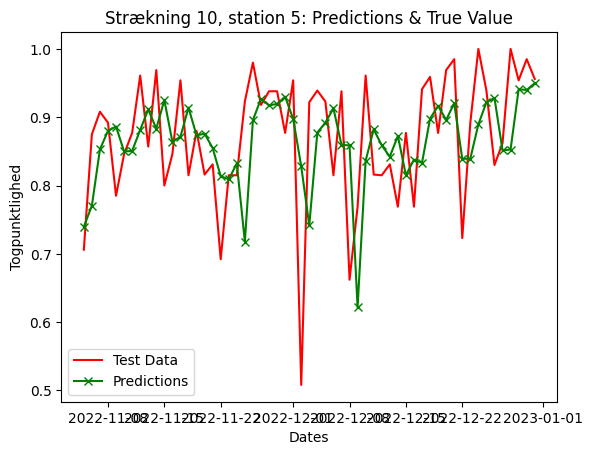

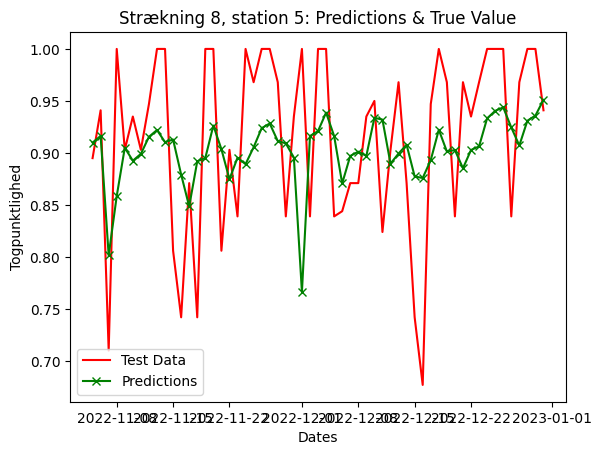

In [73]:
for strækning, station in combinations[:10]:
    y_test = data[(data['visualiseringskode'] == strækning) & (data['station'] == station)]['togpunktlighed'][initial_start:]
    plt.plot(y_test.index, y_test, color='red', label='Test Data')
    plt.plot(y_test.index, preds[(strækning,station)], color='green', marker='x',
                label='Predictions')
    plt.title(f'Strækning {strækning}, station {station}: Predictions & True Value')
    plt.xlabel('Dates')
    plt.ylabel('Togpunktlighed')
    plt.legend(loc='lower left')
    plt.show()

In [5]:
# Feature importance is numpy array
# Real for HPC
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
import xgboost as xgb
import ast
import catboost as cb

from matplotlib.ticker import MaxNLocator
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict


# Import data
data = pd.read_csv("Data/Cleaned_data.csv")

#Unique combinations of strækning/station
combinations = data[['visualiseringskode', 'station']].drop_duplicates().values

# Retrieve best model parameters for ARIMA models for strækning/station
best_model_parameters = {}
model_params_sarima = pd.read_csv('Data/Best_model_parameters_SARIMA_strækning_station.csv')
list(model_params_sarima.items())
for i in range(model_params_sarima.shape[0]):
    tuple_result = ast.literal_eval(model_params_sarima['Key'][i])
    list_result = ast.literal_eval(model_params_sarima['Values'][i])
    best_model_parameters[tuple_result] = list_result

# Customized cross validation with rolling window and XGboost
def custom_cross_val_predict(estimator, y, X=None, cv=None, verbose=0, averaging="mean", return_raw_predictions=False, initial=2555):
    """Generate cross-validated estimates for each input data point
    
    Parameters
    ----------
    estimator : tuple
        A tuple containing two estimators. The first estimator should be the ARIMA model
        and the second one should be the Random Forest model.

    y : array-like or iterable, shape=(n_samples,)
        The time-series array.

    X : array-like, shape=[n_obs, n_vars], optional (default=None)
        An optional 2-d array of exogenous variables.

    cv : BaseTSCrossValidator or None, optional (default=None)
        An instance of cross-validation. If None, will use a RollingForecastCV.
        Note that for cross-validation predictions, the CV step cannot exceed
        the CV horizon, or there will be a gap between fold predictions.

    verbose : integer, optional
        The verbosity level.

    averaging : str or callable, one of ["median", "mean"] (default="mean")
        Unlike normal CV, time series CV might have different folds (windows)
        forecasting the same time step. After all forecast windows are made,
        we build a matrix of y x n_folds, populating each fold's forecasts like
        so::

            nan nan nan  # training samples
            nan nan nan
            nan nan nan
            nan nan nan
              1 nan nan  # test samples
              4   3 nan
              3 2.5 3.5
            nan   6   5
            nan nan   4

        We then average each time step's forecasts to end up with our final
        prediction results.

    return_raw_predictions : bool (default=False)
        If True, raw predictions are returned instead of averaged ones.
        This results in a y x h matrix. For example, if h=3, and step=1 then:

            nan nan nan # training samples
            nan nan nan
            nan nan nan
            nan nan nan
            1   4   2   # test samples
            2   5   7
            8   9   1
            nan nan nan
            nan nan nan

        First column contains all one-step-ahead-predictions, second column all
        two-step-ahead-predictions etc. Further metrics can then be calculated
        as desired.

    Returns
    -------
    predictions : array-like, shape=(n_samples,)
        The predicted values.

    """

    def indexable(*iterables):
        """Internal utility to handle input types"""
        results = []
        for iterable in iterables:
            if not hasattr(iterable, "__iter__"):
                raise ValueError("Input {!r} is not indexable".format(iterable))
            results.append(iterable)
        return results

    def check_cv(cv, initial = 2555):
        """Internal utility to check cv"""
        if cv is None:
            from pmdarima.model_selection import RollingForecastCV
            cv = RollingForecastCV(initial=initial, step=1, h=1)
        return cv

    def check_endog(y, copy=True, preserve_series=False):
        """Internal utility to check endogenous variable"""
        from pmdarima.utils import check_endog
        return check_endog(y, copy=copy, preserve_series=preserve_series)

    def _check_averaging(averaging):
        """Internal utility to check averaging"""
        if averaging == "mean":
            return np.nanmean
        elif averaging == "median":
            return np.nanmedian
        elif callable(averaging):
            return averaging
        else:
            raise ValueError("Unknown averaging method: {}".format(averaging))

    def _fit_and_predict(fold, estimator_tuple, y, X, train, test, verbose=1):
        """Internal utility to fit and predict"""
        arima_model = estimator_tuple
        # Fit ARIMA model
        arima_model.fit(y[train]) # X=X.iloc[train, :]
        # Predict with ARIMA model
        train_predictions = arima_model.predict_in_sample()
        arima_pred = arima_model.predict(n_periods=len(test))
        arima_pred_cap = np.array(max(min(1, arima_pred[0]), 0))
        # Calculate residuals for RF input
        arima_residuals_train = train_predictions - y[train]

        model = cb.CatBoostRegressor(objective = 'MAE', iterations=20, learning_rate=0.1, max_depth=5, verbose=0) 
        # Train the model
        #model = model.fit(D_train, steps, watchlist)
        model = model.fit(X.iloc[train,1:], arima_residuals_train)
        # Predict the labels of the test set
        #preds = model.predict(D_test)
        preds = model.predict(X.iloc[test,1:])
        # Overall prediction residuals = pred - true <=> true = pred - residuals
        overall_pred = np.array(max(min(1, arima_pred[0] - preds), 0)) # make sure it is in [0;1]

        return overall_pred, test, arima_pred_cap, model.feature_importances_ #arima_residuals_test

    y, X = indexable(y, X)
    y = check_endog(y, copy=False, preserve_series=True)
    cv = check_cv(cv, initial)
    avgfunc = _check_averaging(averaging)

    if cv.step > cv.horizon:
        raise ValueError("CV step cannot be > CV horizon, or there will be a gap in predictions between folds")

    prediction_blocks = [
        _fit_and_predict(fold,
                         estimator,
                         y,
                         X,
                         train=train,
                         test=test,
                         verbose=verbose,)  # TODO: fit params?
        for fold, (train, test) in enumerate(cv.split(y, X))]

    pred_matrix = np.ones((y.shape[0], len(prediction_blocks))) * np.nan
    arima_pred = []
    feature_importances = np.zeros((211,))
    for i, (pred_block, test_indices, arima_block, feature_importance) in enumerate(prediction_blocks):
        pred_matrix[test_indices, i] = pred_block
        arima_pred.append(arima_block)
        feature_importances += feature_importance


    if return_raw_predictions:
        predictions = np.ones((y.shape[0], cv.horizon)) * np.nan
        for pred_block, test_indices in prediction_blocks:
            predictions[test_indices[0]] = pred_block
        return predictions

    test_mask = ~(np.isnan(pred_matrix).all(axis=1))
    predictions = pred_matrix[test_mask]



    # Calculate CV score
    cv_scores = []
    cv_scores_arima = []
    for fold, (train, test) in enumerate(cv.split(y, X)):
        fold_predictions = pred_matrix[test, fold]
        fold_score = float(abs(y[test] - fold_predictions))
        fold_arima_score = float(abs(y[test] - arima_pred[fold]))
        cv_scores.append(fold_score)
        cv_scores_arima.append(fold_arima_score)

    # Compute overall CV score
    score = np.mean(cv_scores)
    arima_score = np.mean(cv_scores_arima)

    return avgfunc(predictions, axis=1), arima_pred, score,  arima_score, cv_scores, cv_scores_arima, feature_importances

# Get CV, errors and prediction for strækning/station
results_strækning_station = {}
combinations = data[['visualiseringskode', 'station']].drop_duplicates().values
MSEs = []
MSEs_arima = []
MSE_strækingstation = []
random_state = 42
preds = {}
cv_scores = {}
importance_features = np.zeros((211,))

for strækning, station in combinations[:2]:
    y = data[(data['visualiseringskode'] == strækning) & (data['station'] == station)]['togpunktlighed'].values
    X = data[(data['visualiseringskode'] == strækning) & (data['station'] == station)].iloc[:,1:]
    arima_model = pm.arima.ARIMA(order = best_model_parameters[strækning, station][0], seasonal_order=best_model_parameters[strækning, station][1])
    initial_start = y.shape[0] - 2
    pred_full, pred_arima, mse, mse_arima, cv_score, cv_score_arima, feature_importances = custom_cross_val_predict((arima_model), y, X, cv=None, verbose=1, averaging="mean", return_raw_predictions=False, initial=initial_start)
    # output = prediction per fold. 
    MSEs.append(mse)
    MSEs_arima.append(mse_arima)
    MSE_strækingstation.append(str((int(strækning), int(station))))
    preds[str((int(strækning), int(station))) + '_arima'] = pred_arima
    preds[str((int(strækning), int(station))) + '_full'] = pred_full
    cv_scores[str((int(strækning), int(station))) + '_arima'] = cv_score_arima
    cv_scores[str((int(strækning), int(station))) + '_full'] = cv_score
    importance_features += feature_importances

    # initial = 2457 - 100 fold, 10 combinations, n_estimators=100 -> 61 min

preds_dataframe = pd.DataFrame(preds)
cv_scores_dataframe = pd.DataFrame(cv_scores)
errors_dataframe = pd.DataFrame({'Strækning/station': MSE_strækingstation, 'Error_arima': MSEs_arima, 'Error_full': MSEs}) # Could easily be calculated from cv_scores?
importance_dataframe = pd.DataFrame(importance_features.reshape(1,-1), columns=list(data.columns[2:]))

preds_dataframe.to_csv('Results/SARIMA_Catboost_CV_preds.csv', index=False)
cv_scores_dataframe.to_csv('Results/SARIMA_Catboost_CV_scores.csv', index=False)
errors_dataframe.to_csv('Results/SARIMA_Catboost_CV_errors.csv', index = False)
importance_dataframe.to_csv('Results/SARIMA_Catboost_CV_importance.csv', index = False)